In [1]:
#near duplicate detection and elimination
#next steps - obtain more data
#near entity recognition - spacy
#relabeling

# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [2]:
data_path = '../data/training_test_data/'
data = pd.read_csv(data_path + 'after_stock_data_cleaned.csv')
colnames = ['headline','source','label']   
data.columns = colnames

data2 = pd.read_csv(data_path + 'now_data_parsed.csv')

data2.columns = ['headline','label']

#getting data we have labeled out of the unlabeled data

data2_labeled = pd.concat([data2[438:2438], data2[6448:8448],data2[12458:14458],data2[18468:20709],data2[24478:26479]], sort=False)

data2_labeled.head()

,headline,label
438,amazon opens preorders for cinderella annivers...,1
439,google researchers add attention to augment co...,1
440,android q the choice of the final name for goo...,1
441,google to phase out works with nestprogram in ...,1
442,google announces major android auto update wit...,1


In [3]:
#concatenate our data to their data

from sklearn.utils import shuffle

data = pd.DataFrame({'headline':data['headline'], 'label':data['label']}, columns=['headline', 'label'])

df_union = shuffle(pd.concat([data, data2_labeled], sort=False))

,headline,label
6466,intel don't expect google stadia will affect c...,1
1542,The Sony noise cancelling headphones that blow...,1
603,buy amazon better than buffett did,1
18547,how do you use google team drives especially f...,1
19678,missing schoolboy found safe and well and reun...,0


In [4]:
#this is less balanced now with the addition of new data and new labeling rules
df_union['label'].value_counts()

1    11962
0     2223
Name: label, dtype: int64

In [5]:
import re

df_union['headline'] = df_union['headline'].str.replace("[^a-zA-Z]", " ")

In [6]:
word_count = sum(len(headline.split(' ')) for headline in df_union['headline'])

print(word_count)

231580


In [7]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df_union[['label','headline']], stratify = df_union['label'], test_size = 0.2, random_state = 12)
print('{}, {}'.format(len(df_trn), len(df_val)))

11348, 2837


In [8]:
unlabeled_headlines = pd.read_csv(r'C:\Users\amber\Documents\VSE\DAEN 690\repo\DAEN-690\data\raw_data\Nowigence Raw Data.csv')

unlabeled_headlines.columns = ['headline']

text_df = pd.DataFrame(pd.concat([data['headline'], data2['headline']]))
text_df['label'] = 0

txt_trn, txt_val = train_test_split(text_df[['label','headline']], stratify = text_df['label'], test_size = 0.2, random_state = 12)

print('{}, {}'.format(len(txt_trn), len(txt_val)))

text_df.head()

27545, 6887


,headline,label
0,"Apple, Amazon, YouTube: Safer, faster &amp; le...",0
1,5G Stocks: Will Amazon Dip Its Toes In?,0
2,Fear of Amazon Creates a Bargain in FedEx Stock,0
3,Amazon Buyout Buzz Draws Options Bulls to Grub...,0
4,US Stock Market Overview – Stocks Surge With O...,0


In [19]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = txt_trn, valid_df = txt_val, path = "", num_workers = 0)

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32, num_workers = 0)

In [13]:

#data_lm.save('models/data_lm_export.pkl')
#data_clas.save('models/data_clas_export.pkl')

#data_lm = load_data('models/data_lm_export.pkl')

#data_clas = load_data('models/data_clas_export.pkl', bs=1)

learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.5)

In [ ]:
learn.fit_one_cycle(1, 1e-2)

In [12]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.094942,4.154446,0.317313,27:39
1,3.924717,3.988525,0.338732,27:36
2,3.477757,3.821446,0.366554,27:36
3,2.888181,3.715166,0.389741,27:36
4,2.436256,3.743557,0.393670,27:44


In [20]:
#I probably don't need to import all of these...I'll do more research to figure out just what I'm using below

from fastai.torch_core import *
from fastai.callback import *
from fastai.layers import *
from fastai.basic_train import LearnerCallback

#based on fastai's built in fbeta and accuracy metrics - the fbeta that is built in only works on one hot encoded multiclass targets

def fscore(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, beta:float=1, eps:float=1e-9, sigmoid:bool=True)->Rank0Tensor:
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2
    n = y_true.shape[0]
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = y_pred.argmax(dim=-1).view(n,-1)
    y_true = y_true.view(n,-1)
    TP = (y_pred*y_true).float().sum()
    prec = TP/(y_pred.float().sum()+eps)
    rec = TP/(y_true.float().sum()+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.float().mean()

In [21]:
#learn.save_encoder('ft_enc')
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.7, metrics = fscore)
learn.load_encoder('ft_enc')

In [22]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,fscore,time
0,0.380662,0.297038,0.916706,08:37
1,0.345088,0.296458,0.915642,1:28:28
2,0.315869,0.296315,0.921305,17:22
3,0.309613,0.285506,0.921199,14:21
4,0.300211,0.284238,0.920988,18:12


In [17]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,fscore,time
0,0.315457,0.283867,0.929309,21:00


In [70]:
error_analysis = pd.DataFrame(pd.read_csv(r'C:\Users\amber\Documents\VSE\DAEN 690\repo\DAEN-690\data\output_data\error_analysis.csv'))
predictions = learn.get_preds()
#learn.show_results()
#error_analysis.head()

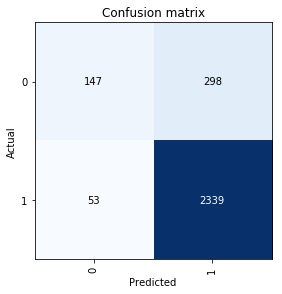

In [71]:
txt_ci = TextClassificationInterpretation.from_learner(learn)
txt_ci.plot_confusion_matrix()

In [72]:
txt_ci.show_top_losses(10)

Text,Prediction,Actual,Loss,Probability
xxbos xxmaj apple xxmaj amazon youtube xxmaj safer faster amp less annoying,1,0,5.06,0.01
xxbos google chrome new settings page lands in canary,1,1,4.96,0.99
xxbos daily crunch amazon backs deliveroo,1,1,4.81,0.99
xxbos avoid getting a ticket get xxunk xxunk car mount for amazon deals,1,1,4.54,0.99
xxbos huge amazonowned whole foods xxunk crypto by accepting bitcoin,1,0,4.18,0.02
xxbos xxmaj renault board to vote next week on merger with xxmaj fiat xxmaj chrysler,1,1,4.08,0.98
xxbos google pixel a vs pixel an inhouse competition,1,1,3.97,0.98
xxbos reliance jio reportedly working on a super app expected to compete with amazon xxunk news firstpost,1,1,3.89,0.98
xxbos xxmaj is the xxmaj world xxmaj ready for xxmaj more xxmaj music from xxmaj lindsay xxmaj xxunk,1,1,3.68,0.97
xxbos ios xxmaj the iphone and ipad models that won t be able to update to new operating system,1,1,3.46,0.97


In [ ]:
params = hkl.load('resnet-18-export.hkl')

# convert numpy arrays to torch Variables
for k in sorted(params.keys()):
    v = params[k]
    print(k, v.shape)
    params[k] = Variable(torch.from_numpy(v), requires_grad=True)